In [4]:
import numpy as np

import matplotlib.pyplot as plt

import ChevKasen_tools as ckt
import Const as C

In [92]:
%matplotlib notebook

In [41]:
M_EJ_REF = 1.38*C.M_SUN

### Shock dynamics ###
The Chevalier self-similar shock radius solution for ejecta of density
$$
\rho_\mathrm{ej} = g^n t^{n-3} r^{-n}
$$
interacting with CSM of density
$$
\rho_\mathrm{cs} = q r^{-s}
$$
is
$$
R_c = \left(\frac{Ag^n}{q}\right)^{1/(n-s)} t^{(n-3)/(n-s)} ~,
$$
where $A$ is a numerical value set by $n$ and $s$. 
The forward shock radius, $R_f$ ($R_1$, in his original paper), and reverse shock radius, $R_r$ (or $R_2$), are constant multiples of $R_c$ for a given $n$ and $s$. 

Then the **speed of the forward shock** is
$$
v_s = \frac{R_1}{R_c} \frac{dR_c}{dt} = \frac{R_1}{R_c} \frac{(n-3)}{(n-s)} \frac{R_c}{t} = \frac{(n-3)}{(n-s)} \frac{R_f}{t}
$$

In [30]:
def calc_tgrid(Rf, q, g_tothe_n, n=10, s=2):
    """
    Calculates the times corresponding to the forward shock
    being at radius Rf for a given q value
    INPUTS
    Rf       : forward shock radius in cm (float or array)
    q        : CSM density normalization (float or array)
    g_tothe_n: ejecta density normalization (float)
    n        : powerlaw index of ejecta (int)
    s        : powerlaw index of CSM (int)
    OUTPUTS
    grid of times
    """
    assert n!=3
    
    A = ckt.get_A(s,n)
    
    orig_term = (A*g_tothe_n/q)**(1/(n-s))

    t = (Rf/orig_term)**((n-s)/(n-3))
    
    return t

In [25]:
def calc_vf(Rf, t, n=10, s=2):
    """
    Calculates forward shock speed 
    INPUTS
    Rf : forward shock radius in cm
    t  : time in s -- should be same size as Rf or a float
    n  : powerlaw index of ejecta
    s  : powerlaw index of CSM
    OUTPUTS
    shock speed at each Rf, in cm/s
    """
    return (n-3)/(n-s) * Rf/t

The **hydrodynamical timescale** is $t_\mathrm{hy} = R_f/v_s = t (n-s)/(n-3)$.

In [27]:
def calc_thydro(t,n=10,s=2):
    """
    Calculates the hydrodynamical time
    INPUTS
    t  : time in s 
    n  : powerlaw index of ejecta
    s  : powerlaw index of CSM
    OUTPUTS
    hydrodynamical time in s
    """
    assert n!=3
    
    return t * (n-s)/(n-3)

### Postshock electron temperature 

**Electron temperature - dense gas.** If the gas is dense enough to trap photons, then the shocked gas will be radiation-pressure dominated and the gas temperature (assuming radiative equilibrium) will be set by the radiation temperature, $T_\mathrm{rad}$, which is
$$
aT_\mathrm{rad}^4 = \rho_s v_s^2 ~,
$$
where $\rho_s$ is the density of the shocked CSM. The density of the postshock CSM is related to the preshock CSM density by a factor $\eta$, which I need to look up for the case of $\gamma_\mathrm{ad} = 5/3$ on pre-shock side and $\gamma_\mathrm{ad} = 4/3$ on post-shock side, but $\eta$ is presumably between 4 and 7. 
Then
$$
T_e = T_\mathrm{rad} = (\eta \rho_\mathrm{cs} v_s^2 / a)^{1/4} = T_i
$$


In [31]:
def calc_Trad(rho_cs, v_s, eta=7):
    """
    Calculates the radiation temperature of the 
    immediate postshock gas
    INPUTS
    rho_cs: CSM density at forward shock, in g cm^-3
    v_s   : forward shock speed, in cm/s
    eta   : compression ratio for CSM
    OUTPUTS
    radiation temperature in K
    """
    return (eta*rho_cs/C.A_RAD)**(1/4) *np.sqrt(v_s)

**Electron temperature - low-density gas.** If photons can free-stream from the shocked gas, then it will be gas-pressure dominated. The *ion* temperature will be set by
$$
T_i = \frac{3m_p}{16k_B} \mu_s v_s^2 ~. 
$$
The timescale for electrons and ions to come into equilibrium is
$$
t_{e-p} = (14~\mathrm{s})~T_s^{3/2} n_s^{-1} 
        = (14~\mathrm{s})~T_s^{3/2} (\mu_s m_p) (\eta \rho_\mathrm{cs})^{-1} \\
        = (14~\mathrm{s})~\left[\left(\frac{3\mu_s m_p}{16k_B}\right)^{3/2} v_s^3\right] (\mu_s m_p) (\eta \rho_\mathrm{cs})^{-1}
        = (14~\mathrm{s})~\left(\frac{3}{16k_B}\right)^{3/2} (\mu_s m_p)^{5/2} v_s^3 (\eta \rho_\mathrm{cs})^{-1} \\
        = (25.35~\mathrm{s})~\mu_s^{5/2} v_{s,8}^3 (\eta\rho_\mathrm{cs,-13})^{-1} ~,
$$
where in the last expression $v_{s,8} = v_s/(1,000~\mathrm{km~s^{-1}})$ and $\rho_\mathrm{cs,-13} = \rho_\mathrm{cs}/(10^{-13}~\mathrm{g~cm^{-3}})$.

The electrons will start at a temperature
$$
T_e = (m_e/m_i) T_i
$$
and within the collisional timescale will warm to $T_i$. Therefore, 
$$
\frac{m_e}{m_i} \frac{3m_p}{16k_B} \mu_s v_s^2 \leq T_e \leq \frac{3m_p}{16k_B} \mu_s v_s^2
$$

In [221]:
def calc_collision_time(rho_cs, v_s, eta=4, mu_s=1):
    """
    Calculates the electron-ion Coulomb collision time
    INPUTS
    rho_cs : CSM density at location of forward shock, in g/cc
    v_s    : forward shock speed, in cm/s
    eta   : compression ratio for CSM
    mu_s   : mean molecular weight of postshock CSM
    OUTPUTS
    collision time in s
    """
    
    t = 14 *(3/(16*C.K_B))**1.5 * (mu_s*C.M_P)**2.5 * v_s**3 /(eta*rho_cs)
    return t

In [32]:
def calc_gasdom_Te(v_s, mu_s=1, elec_ion_rat=1):
    """
    Calculates the electron temperature assuming 
    gas-pressure dominated postshock region
    (therefore gamma_ad=5/3 and eta=4)
    INPUTS
    v_s : forward shock speed, in cm/s
    mu_s: mean molecular weight of postshock CSM
    elec_ion_rat : ratio of electron temperature to ion temperature
    OUTPUTS
    electron temperature in K
    """

    Ti = 3*C.M_P/(16*C.K_B) * mu_s*v_s**2
    
    return elec_ion_rat*Ti

#### Photon trapping. 

The optical depth of the postshock gas to electron scattering is 
$$
\tau_\mathrm{es} = n_e \Delta R_s \sigma_T = \eta \rho_\mathrm{cs}/(\mu_e m_p) \Delta R_s \sigma_T = 0.4 \eta \mu_e^{-1} \rho_\mathrm{cs} \Delta R_s ~. 
$$
Assuming the self-similar model, 
$$
\Delta R_s = R_1 - R_2 = (1 - \frac{R_2}{R_1}) R_1 
           = \left[ 1 - \left(\frac{R_2}{R_c}\right)\left(\frac{R_1}{R_c}\right)^{-1} \right] R_1
$$

In [44]:
def calc_shock_width(Rf, q, n=10, s=2):
    """
    Calculates the width of the shock region
    INPUTS
    Rf  : forward shock radius (cm)
    q   : CSM density normalization (float or array)
    n   : powerlaw index of ejecta
    s   : powerlaw index of CSM
    OUTPUTS
    width of the shock region in cm
    """
    dR = (1 - ckt.get_R2factor(s,n)/ckt.get_R1factor(s,n))*Rf
    return dR

In [206]:
def calc_tau_es(Rf, q, eta=4, mu_e=1, n=10, s=2, M_ej=M_EJ_REF):
    """
    Calculates the optical depth of the shock to electron scattering
    INPUTS
    Rf  : forward shock radius (cm)
    q   : CSM density normalization (float or array)
    n   : powerlaw index of ejecta
    s   : powerlaw index of CSM
    OUTPUTS
    optical depth due to Thomson scattering
    """
    rho_cs = q*Rf**-s
    dR = calc_shock_width(Rf, q, n=n, s=s)
    return 0.4*eta/mu_e * rho_cs*dR

### Gas cooling

**Cooling time of relativistic electrons (synchrotron emitters).** The cooling time of a relativistic electron with Lorenz factor $\gamma$ is 
$$
t_\mathrm{cool} \sim \frac{\gamma m_e c^2}{\frac{4}{3} \sigma_T c u_B \gamma^2} ~.
$$
If $u_B = \epsilon_B u_\mathrm{gas}$ then 
$$
u_B = \epsilon_B \frac{\eta \rho_\mathrm{cs}}{\mu_{i,s} m_p} k_B T_i 
$$
and so
$$
t_\mathrm{cool} \sim (0.373~\mathrm{s}) \frac{\mu_{i,s}}{\gamma \eta \epsilon_B \rho_\mathrm{cs} T_i }
$$
with $\rho_\mathrm{cs}$ in grams and $T_i$ in K.

In [281]:
def calc_tcool_rel_e(rho_cs, Ti, mu_i=1, epsilon_B=0.1, eta=4, gamma=10):
    """
    Calculates the cooling time for postshock 
    relativistic electrons of Lorentz factor gamma
    INPUTS
    rho_cs : preshock CSM density
    Ti     : postshock ion temperature
    mu_i   : postshock ion mean molecular weight
    epsilon_B : ratio of magnetic to gas energy density
    eta    : compression ratio (ratio of postshock to preshock mass density)
    gamma  : Lorentz factor of electron
    OUTPUT
    cooing time of relativistic electrons, in s
    """    
    return 0.373*mu_i/(gamma*eta*epsilon_B*rho_cs*Ti)

**Cooling time of bulk gas.** This can be approximated as 
$$
t_\mathrm{cool} = \frac{nk_BT_s}{(\gamma_\mathrm{ad}-1)\Lambda}
$$
where
$$
\Lambda = (1.7\times10^{-18}~\mathrm{erg\ cm^3\ s^{-1}})~ n_e n_H T_s^{-0.7}
$$
with temperature measured in K. 
Thus,
$$
t_\mathrm{cool} = \frac{k_B}{(\gamma_\mathrm{ad}-1)(1.7\times10^{-18}~\mathrm{erg\ cm^3\ s^{-1}})}\frac{n}{n_e n_H} T_s^{1.7}
$$
or, measuring density in per cubic centimeters,
$$
t_\mathrm{cool} = (81.2~\mathrm{s})~ \frac{n}{n_e n_H} T_s^{1.7}\frac{1}{\gamma_\mathrm{ad}-1} \\
= (1.4\times10^{-22}~\mathrm{s})~ \frac{\mu_e}{\mu_s} (\eta \rho_\mathrm{cs})^{-1} T_s^{1.7}\frac{1}{\gamma_\mathrm{ad}-1}
$$
where the final expression assumes $\rho_\mathrm{cs}$ is measured in units of $\mathrm{g\ cm^{-3}}$.

In [280]:
def calc_tcool_gas(rho_cs, Te, mu_s=1, mu_e=1, eta=4, gamma_ad=1.666667):
    """
    Calculates the cooling time for postshock gas
    INPUTS
    rho_cs  : preshock CSM density
    Te      : postshock electron temperature
    mu_s    : postshock total mean molecular weight
    mu_e    : postshock electron mean molecular weight
    eta     : compression ratio (ratio of postshock to preshock mass density)
    gamma_ad: gamma-law equation of state gamma
    OUTPUT
    cooing time of relativistic electrons, in s
    """    
    return 1.4e-22 * mu_e/(mu_s*eta*rho_cs) * Te**1.7 * 1/(gamma_ad-1)

## Plot quantities

In [71]:
s = 2
n = 10
g_tothe_n = ckt.calc_g_tothe_n(s, n, M_ej = M_EJ_REF)

In [190]:
# Define the CSM parameter space
Mdot = np.logspace(-9,-4,9-4+1) # solar masses per year
vw = np.logspace(1,3,3-1+1) # km/s

#all_q = 10**np.unique(np.log10(np.outer(Mdot,1/vw)).flatten())
#all_q.sort()

q = np.outer(Mdot,1/vw).flatten()
all_q = np.logspace(np.log10(q.min()),np.log10(q.max()),30)

x = all_q.copy() # this is what I want the x-axis to be

all_q *= C.M_SUN/C.YR2SEC # make mass-loss rate g/s
all_q /= 1e5 # make wind speed cm/s
all_q /= 4*np.pi # q is actually Mdot/vw

In [242]:
# Radii of interest
Rf = np.logspace(11,17,(17-11)*4+1)

In [243]:
QQ, RR = np.meshgrid(all_q, Rf)
XX, RR = np.meshgrid(x, Rf)

In [244]:
# Convert radii into times
TT = calc_tgrid(RR, QQ, g_tothe_n, n=n, s=s)

In [245]:
v_s = calc_vf(RR,TT,n=n,s=s)

<IPython.core.display.Javascript object>


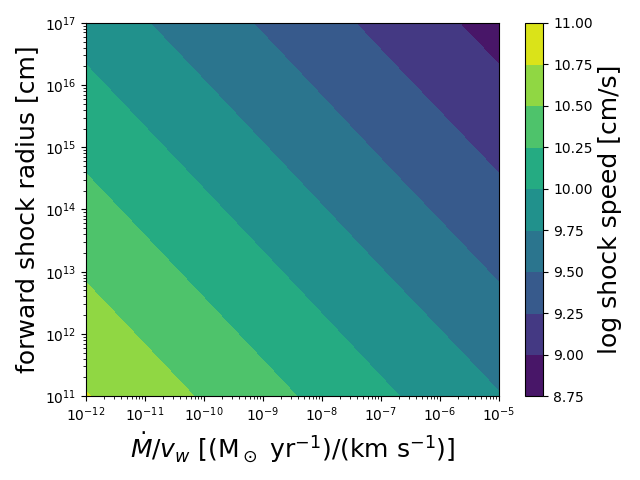

In [246]:
fig,ax=plt.subplots(1)
con = ax.contourf(XX, RR, np.log10(v_s))
cbar=fig.colorbar(con, ax=ax)
cbar.set_label(label='log shock speed [cm/s]',size = 18)
#ax.contour(XX, RR, np.log10(tau), levels=(1,), cmap='Greys')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)

In [247]:
tau = calc_tau_es(RR, QQ, eta=4, mu_e=1, n=n, s=s, M_ej=M_EJ_REF)

<IPython.core.display.Javascript object>


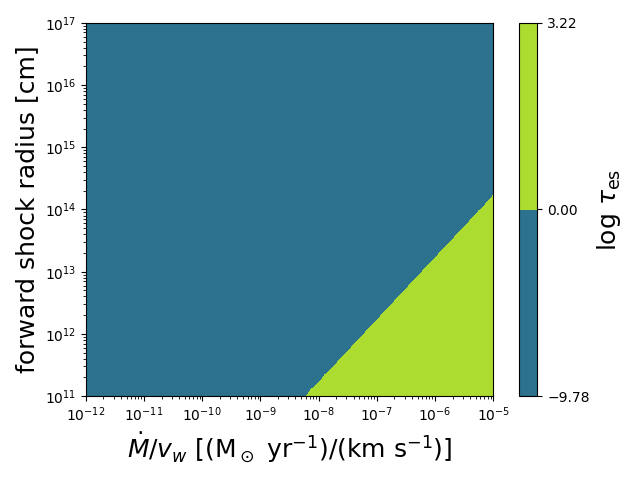

In [265]:
fig,ax=plt.subplots(1)
con = ax.contourf(XX, RR, np.log10(tau), levels=(np.log10(tau.min()),0,np.log10(tau.max())))
cbar=fig.colorbar(con, ax=ax)
cbar.set_label(label='log $\\tau_\mathrm{es}$',size = 18)
#ax.contour(XX, RR, np.log10(tau), levels=(1,), cmap='Greys')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)

In [249]:
rho_cs = QQ* RR**-s
t_ep = calc_collision_time(rho_cs, v_s)
t_hydro = calc_thydro(TT,n=n,s=s)

<IPython.core.display.Javascript object>


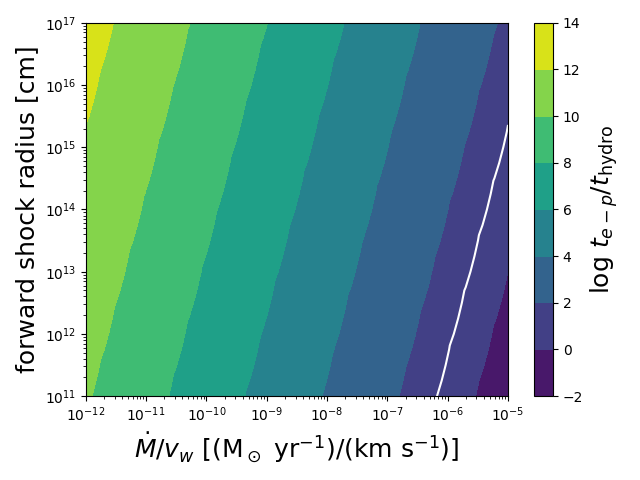

In [250]:
fig,ax=plt.subplots(1)

ZZ=np.log10(t_ep/t_hydro)

con = ax.contourf(XX, RR, ZZ)
cbar = fig.colorbar(con, ax=ax)
cbar.set_label(label='log $t_{e-p}/t_\mathrm{hydro}$',size = 18)
ax.contour(XX, RR, ZZ, levels=(1,), cmap='Greys')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)

In [278]:
Ti = calc_gasdom_Te(v_s, elec_ion_rat=1)
Temp = Ti*(C.M_E/C.M_P)
Trad = calc_Trad(rho_cs, v_s)

Ti[tau>=1] = Trad[tau>=1]
Temp[tau>=1] = Trad[tau>=1]

<IPython.core.display.Javascript object>


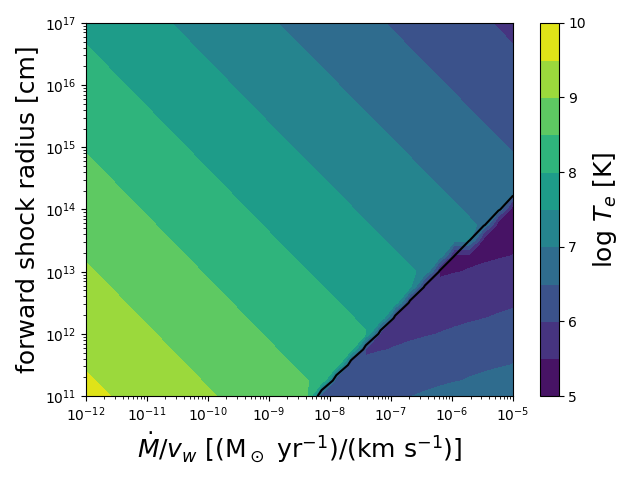

In [273]:
fig,ax=plt.subplots(1)

ZZ=np.log10(Temp)

con = ax.contourf(XX, RR, ZZ, levels=np.arange(5,10.5,.5))
cbar = fig.colorbar(con, ax=ax)
cbar.set_label(label='log $T_e$ [K]',size = 18)

ax.contour(XX, RR, np.log10(tau), levels=(0,), cmap='Greys_r')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)

In [283]:
tcool_rel = calc_tcool_rel_e(rho_cs, Ti)

<IPython.core.display.Javascript object>


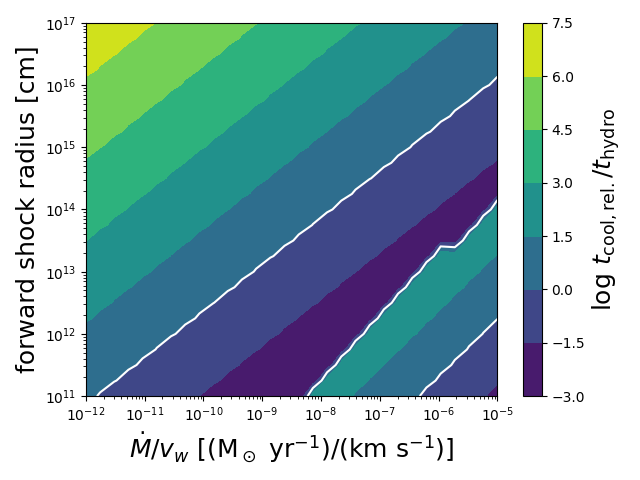

In [285]:
fig,ax=plt.subplots(1)

ZZ=np.log10(tcool_rel/t_hydro)

con = ax.contourf(XX, RR, ZZ)
cbar = fig.colorbar(con, ax=ax)
cbar.set_label(label='log $t_\mathrm{cool, rel.}/t_\mathrm{hydro}$',size = 18)

ax.contour(XX, RR, ZZ, levels=(0,), cmap='Greys')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)

In [286]:
tcool_gas = calc_tcool_gas(rho_cs, Temp)

<IPython.core.display.Javascript object>


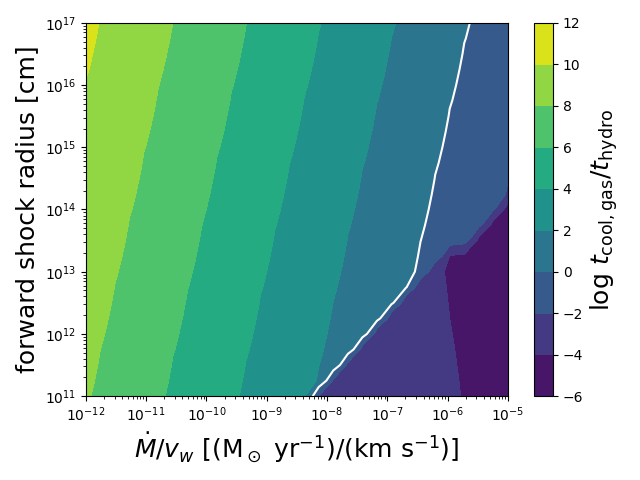

In [287]:
fig,ax=plt.subplots(1)

ZZ=np.log10(tcool_gas/t_hydro)

con = ax.contourf(XX, RR, ZZ)
cbar = fig.colorbar(con, ax=ax)
cbar.set_label(label='log $t_\mathrm{cool, gas}/t_\mathrm{hydro}$',size = 18)

ax.contour(XX, RR, ZZ, levels=(0,), cmap='Greys')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$\dot{M}/v_w\ \mathrm{[(M_\odot\ yr^{-1})/(km\ s^{-1})]}$',size=18)
ax.set_ylabel('forward shock radius [cm]',size=18)

fig.set_tight_layout(True)